In [261]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pprint import pprint
import folium
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import PowerTransformer

In [276]:
class airbnb_city:
    
    def __init__(self, csv):
        
        self.csv = csv
                
        self.df_city = pd.read_csv(self.csv)
        
        print("Instance created!")
        
    def clean_columns(self):
        
        # Take only the relevant columns in the dataframe
        
        l_relevant_columns = ["host_is_superhost","neighbourhood_cleansed","neighbourhood_group_cleansed","property_type","room_type","accommodates","bathrooms_text","beds","price","minimum_nights","maximum_nights","availability_30","availability_365","number_of_reviews","instant_bookable", "amenities", "host_verifications"]

        self.df_city = self.df_city[l_relevant_columns]
        
        self.df_city["bathrooms_text"].replace(np.nan, "?", inplace = True)
        
        # Get numbers out of bathroom_text columns
        
        l_nums = [re.findall(r'\d+',i) for i in self.df_city["bathrooms_text"].values]

        l_nums_completed = []

        for i in l_nums:

            if len(i) > 1:

                l_nums_completed.append('.'.join(i))

            elif len(i) == 0:

                l_nums_completed.append('0')

            else:

                l_nums_completed.append(i[0])

        # Separate categories from bathroom_text
        
        l_category = []

        for i in self.df_city["bathrooms_text"].values:

            if "shared" in i:

                l_category.append("Shared")

            elif "private" in i:

                l_category.append("Private")

            else:

                l_category.append("Unknown")
                
        # Create two different columns replacing bathroom_text
        
        self.df_city.drop("bathrooms_text", axis = 1, inplace = True)
                
        self.df_city["num_of_baths"] = l_nums_completed
        
        self.df_city["bath_category"] = l_category
        
        self.df_city["num_of_baths"] = self.df_city["num_of_baths"].astype("float64")

        # Column["prices"]
        
        self.df_city["price"]  = self.df_city["price"] .apply(lambda x: float(x.strip("$").replace(',', '')) if pd.notnull(x) else x)
        
        self.df_city["amenities"] = [len(i) for i in self.df_city["amenities"]]

        self.df_city["host_verifications"] = [len(i) for i in self.df_city["host_verifications"]]
        
        
        print("Dataframe sucessfully created!")
    
    def label_encoding(self):
        
        self.df_city.dropna(inplace=True)
        
        # Encoding columns with dummies function
        
        def dummies(data, column):
            return pd.get_dummies(data = data[column], drop_first=True)
        
        self.df_city["host_is_superhost"] = dummies(self.df_city, "host_is_superhost")
        self.df_city["instant_bookable"] = dummies(self.df_city, "instant_bookable")
        
        df_room_type = dummies(self.df_city, "room_type")
        df_bath_category = dummies(self.df_city, "bath_category")
        df_bath_category = df_bath_category.rename(columns={'Shared': 'shared_bath', 'Unknown': 'unknoun_bath'})
        
        self.df_city = pd.concat([self.df_city, df_bath_category], axis = 1)

        self.df_city = pd.concat([self.df_city, df_room_type], axis = 1)

        self.df_city.drop("room_type", axis = 1, inplace = True)

        self.df_city.drop("bath_category", axis = 1, inplace = True)
        
        # Encoding categorical columns with labelEncoding function
        
        l_columns_to_labelEncode = ["neighbourhood_cleansed", "property_type", "neighbourhood_group_cleansed"]
        l_columns_encoded = list()

        for i in l_columns_to_labelEncode:

            # Inicializing object LabelEncoder()
            o_labelEncoding = LabelEncoder()

            # Training it with the column data
            o_labelEncoding.fit(self.df_city[i].values)

            # Transform the column
            l_columns_encoded.append(o_labelEncoding.transform(self.df_city[i].values))

        self.df_city["neighbourhood_cleansed"] = l_columns_encoded[0]
        self.df_city["property_type"] = l_columns_encoded[1]
        self.df_city["neighbourhood_group_cleansed"] = l_columns_encoded[2]
        
        print("Dataframe sucessfully encoded!")

        
    def return_df(self):
    
        return self.df_city
    
    def display_df(self):
    
        display(self.df_city)

In [281]:
madrid = airbnb_city("C:\\Users\\ignci\\OneDrive\\Escritorio\\Curso\\Coisigna\\dsb-p2-ml\\ipynbs\datasets\\Madrid air bnb\\listings_detailed.csv")

Instance created!


In [282]:
df = madrid.return_df()

In [283]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

# R**2 = 0.43

In [280]:
df_columns_chosen = df[["host_id", "neighbourhood_group_cleansed", "latitude", "longitude", "room_type","accommodates", "price","minimum_nights","availability_365","number_of_reviews","calculated_host_listings_count", "reviews_per_month"]]

# R**2 = 0.25

In [284]:
df_columns_chosen = df[["neighbourhood_group_cleansed","accommodates", "price","minimum_nights","availability_365","number_of_reviews","calculated_host_listings_count", "reviews_per_month"]]

In [285]:
df_columns_chosen

,neighbourhood_group_cleansed,accommodates,price,minimum_nights,availability_365,number_of_reviews,calculated_host_listings_count,reviews_per_month
0,Chamartín,2,$60.00,1,180,78,1,0.58
1,Latina,1,$31.00,4,364,33,2,0.42
2,Arganzuela,6,$50.00,15,1,0,7,NaN
3,Centro,3,$92.00,5,72,10,1,0.13
4,Arganzuela,1,$26.00,2,365,149,1,1.12
...,...,...,...,...,...,...,...,...
19613,Centro,1,$23.00,30,349,0,8,NaN
19614,Chamberí,1,$21.00,30,350,0,8,NaN
19615,Chamberí,1,$22.00,7,364,0,8,NaN
19616,Salamanca,1,$19.00,30,349,0,8,NaN


In [286]:
df_columns_chosen = df_columns_chosen.dropna()

In [287]:
df_columns_chosen["price"]

0        $60.00
1        $31.00
3        $92.00
4        $26.00
5        $85.00
          ...  
19494    $44.00
19499    $37.00
19500    $70.00
19501    $47.00
19532    $70.00
Name: price, Length: 13981, dtype: object

In [288]:
df_columns_chosen["price"] = df_columns_chosen["price"].apply(lambda x: float(x.strip("$").replace(',', '')) if pd.notnull(x) else x).values

C:\Users\ignci\AppData\Local\Temp\ipykernel_8628\1023210409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_columns_chosen["price"] = df_columns_chosen["price"].apply(lambda x: float(x.strip("$").replace(',', '')) if pd.notnull(x) else x).values


In [289]:
df_columns_chosen

,neighbourhood_group_cleansed,accommodates,price,minimum_nights,availability_365,number_of_reviews,calculated_host_listings_count,reviews_per_month
0,Chamartín,2,60.0,1,180,78,1,0.58
1,Latina,1,31.0,4,364,33,2,0.42
3,Centro,3,92.0,5,72,10,1,0.13
4,Arganzuela,1,26.0,2,365,149,1,1.12
5,Arganzuela,6,85.0,1,365,3,7,0.03
...,...,...,...,...,...,...,...,...
19494,Centro,4,44.0,2,331,1,2,1.00
19499,Centro,2,37.0,2,0,1,1,1.00
19500,Ciudad Lineal,3,70.0,1,89,1,1,1.00
19501,Centro,2,47.0,1,358,2,5,2.00


In [260]:
Counter(df["property_type"])

Counter({'Private room in apartment': 5771,
         'Entire apartment': 9747,
         'Private room in house': 911,
         'Entire loft': 607,
         'Entire condominium': 349,
         'Other': 1875,
         'Private room in condominium': 358})

In [256]:
from collections import Counter
dict_property_types = dict(Counter(df["property_type"]))

In [257]:
dict_property_types[list(dict_property_types.keys())[0]]

5771

In [258]:
list_others = []
for i in dict_property_types.keys():
    
    if dict_property_types[i] < 300:
        
        list_others.append(i)
        
for i in list_others:
    
    df["property_type"].replace(i,"Other", inplace = True)

In [272]:
def dummies(data, column):
    return pd.get_dummies(data = data[column], drop_first=True)

In [273]:
df_room_type = dummies(df_columns_chosen, "room_type")

KeyError: 'room_type'

In [274]:
df_columns_chosen = pd.concat([df_columns_chosen, df_room_type], axis = 1)

In [232]:
df_columns_chosen.drop("room_type", axis = 1, inplace = True)

In [290]:
# Inicializing object LabelEncoder()
o_labelEncoding = LabelEncoder()

# Training it with the column data
o_labelEncoding.fit(df_columns_chosen["neighbourhood_group_cleansed"].values)

# Transform the column
neighbourhood_group_cleansed = o_labelEncoding.transform(df_columns_chosen["neighbourhood_group_cleansed"].values)


In [291]:
df_columns_chosen["neighbourhood_group_cleansed"] = neighbourhood_group_cleansed

C:\Users\ignci\AppData\Local\Temp\ipykernel_8628\2828361925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_columns_chosen["neighbourhood_group_cleansed"] = neighbourhood_group_cleansed


In [292]:
df_columns_chosen

,neighbourhood_group_cleansed,accommodates,price,minimum_nights,availability_365,number_of_reviews,calculated_host_listings_count,reviews_per_month
0,4,2,60.0,1,180,78,1,0.58
1,9,1,31.0,4,364,33,2,0.42
3,3,3,92.0,5,72,10,1,0.13
4,0,1,26.0,2,365,149,1,1.12
5,0,6,85.0,1,365,3,7,0.03
...,...,...,...,...,...,...,...,...
19494,3,4,44.0,2,331,1,2,1.00
19499,3,2,37.0,2,0,1,1,1.00
19500,6,3,70.0,1,89,1,1,1.00
19501,3,2,47.0,1,358,2,5,2.00


# Getting rid of outliers using quantiles

In [293]:
cols = ["price", "minimum_nights", "calculated_host_listings_count",
        "reviews_per_month", "number_of_reviews"]

for col in cols:
    upper_bound = df_columns_chosen[col].quantile(0.95)
    lower_bound = df_columns_chosen[col].quantile(0.05)
    listings = df_columns_chosen[df_columns_chosen[col] < upper_bound]
    listings = df_columns_chosen[df_columns_chosen[col] > lower_bound]

C:\Users\ignci\AppData\Local\Temp\ipykernel_8628\3946210335.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_columns_chosen[numeric_cols] = pt.fit_transform(df_columns_chosen[numeric_cols])


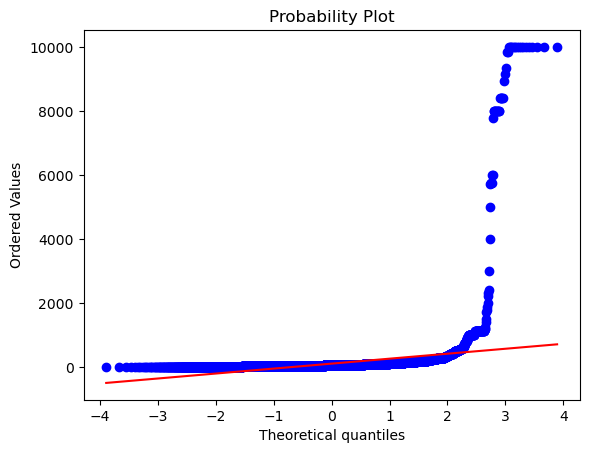

In [294]:
# Plot before transformation
stats.probplot(df_columns_chosen["price"], plot=plt)

# Power Transformer
numeric_cols = list(df_columns_chosen._get_numeric_data().columns)
pt = PowerTransformer(method="yeo-johnson")
df_columns_chosen[numeric_cols] = pt.fit_transform(df_columns_chosen[numeric_cols])

((array([-3.89265493, -3.67198108, -3.55103111, ...,  3.55103111,
          3.67198108,  3.89265493]),
  array([-3.33195413, -3.33195413, -3.08121355, ...,  3.56533681,
          3.56533681,  3.56533681])),
 (0.99757127752642, -3.246289870522459e-16, 0.9973076543913555))

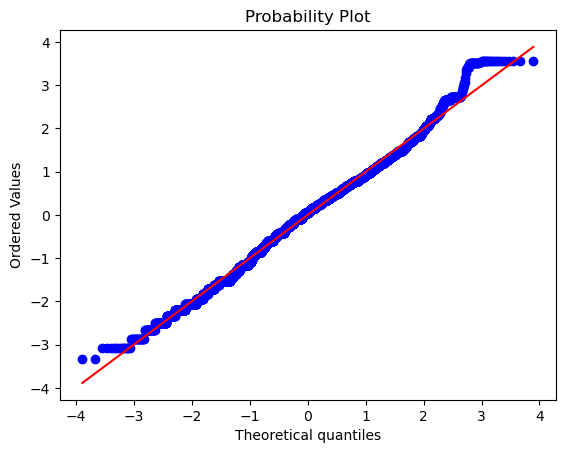

In [295]:
# After transformation
stats.probplot(df_columns_chosen["price"], plot=plt)

In [296]:
df_columns_chosen

,neighbourhood_group_cleansed,accommodates,price,minimum_nights,availability_365,number_of_reviews,calculated_host_listings_count,reviews_per_month
0,-0.164326,-0.544369,0.156251,-1.114435,0.544565,1.063428,-0.979897,-0.101958
1,0.833615,-1.648758,-0.796569,1.007303,1.112689,0.553450,-0.174317,-0.376323
3,-0.475055,0.160786,0.683340,1.225198,-0.037562,-0.193677,-0.979897,-1.062389
4,-2.296705,-1.648758,-1.080978,0.094146,1.115141,1.425795,-0.979897,0.527799
5,-2.296705,1.368129,0.590690,-1.114435,1.115141,-0.932204,0.976580,-1.384548
...,...,...,...,...,...,...,...,...
19494,-0.475055,0.666904,-0.269280,0.094146,1.028966,-1.479153,-0.174317,0.416157
19499,-0.475055,-0.544369,-0.523790,0.094146,-1.406846,-1.479153,-0.979897,0.416157
19500,0.313833,0.160786,0.353998,-1.114435,0.083294,-1.479153,-0.979897,0.416157
19501,-0.475055,-0.544369,-0.175607,-1.114435,1.097877,-1.155009,0.725585,1.081942


# Outliers

neighbourhood_group_cleansed


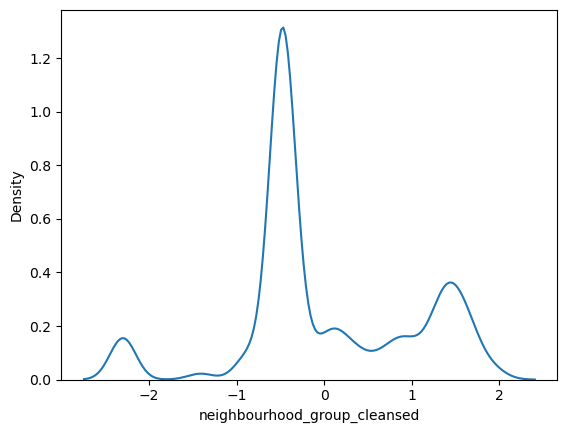

accommodates


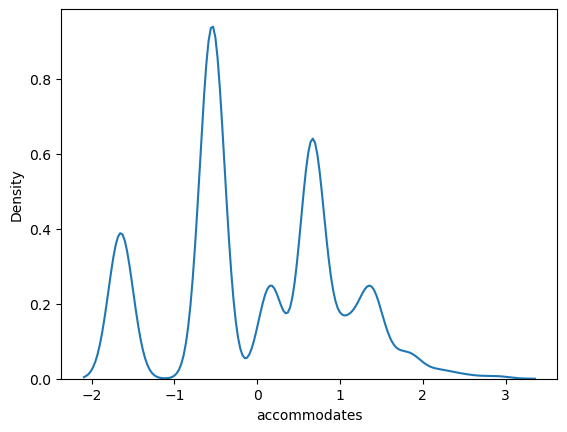

price


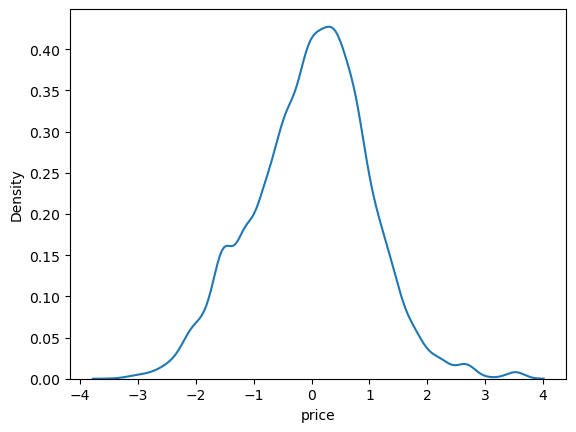

minimum_nights


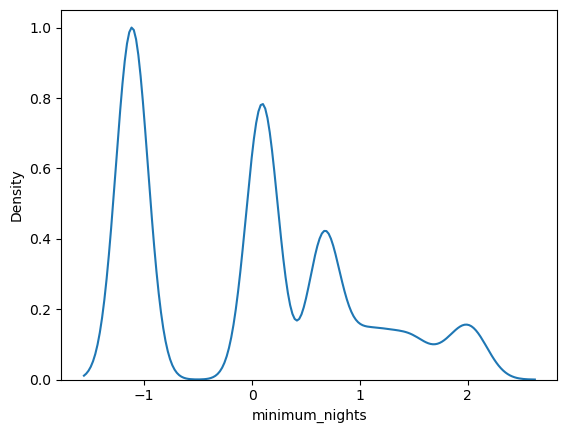

availability_365


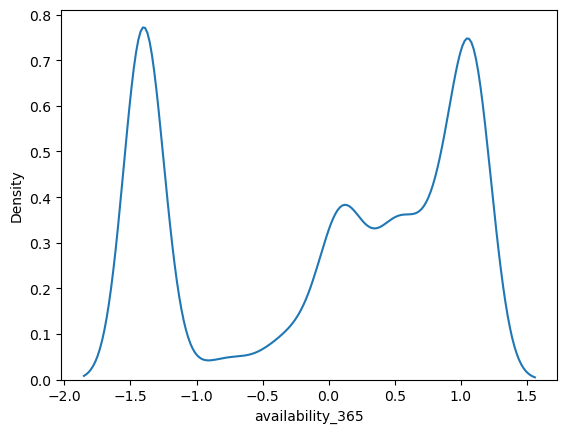

number_of_reviews


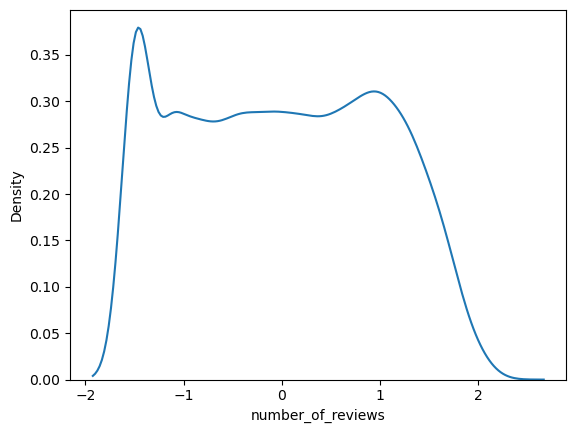

calculated_host_listings_count


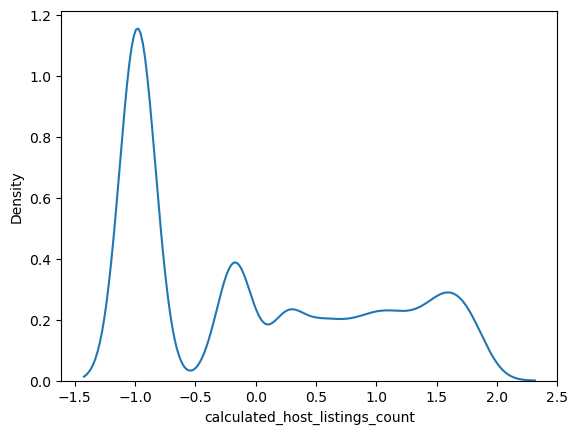

reviews_per_month


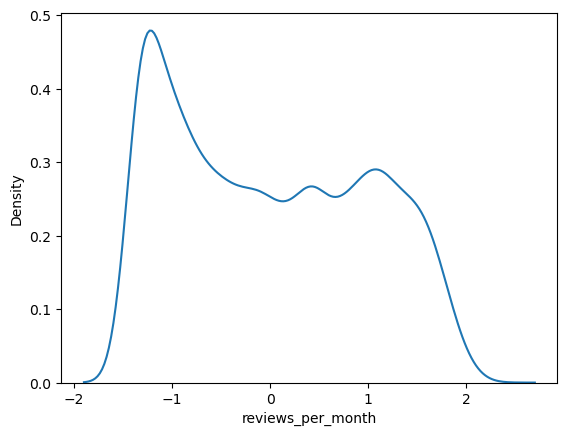

In [297]:
for i in df_columns_chosen.columns:
    
    print(i)
    sns.kdeplot(df_columns_chosen[i])
    plt.show()

In [227]:
df.shape

(18700, 21)

In [228]:
df = df[df["beds"]<15]

In [229]:
df.shape

(18686, 21)

In [230]:
df = df[df["accommodates"]<13]

In [231]:
df.shape

(18637, 21)

In [310]:
df = df[df["price"]<700]

<AxesSubplot:xlabel='price', ylabel='Count'>

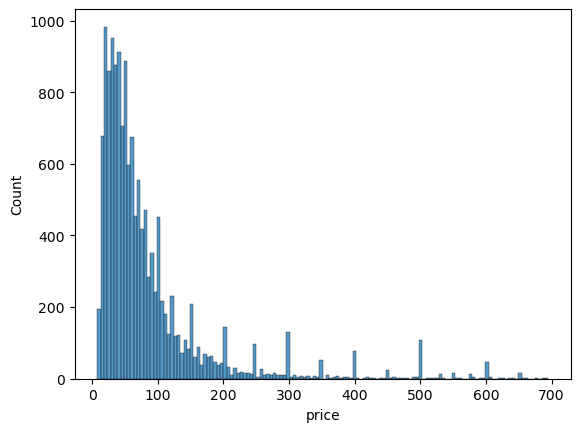

In [311]:
sns.histplot(df[df["host_is_superhost"] == 0]["price"])

<AxesSubplot:xlabel='price', ylabel='Count'>

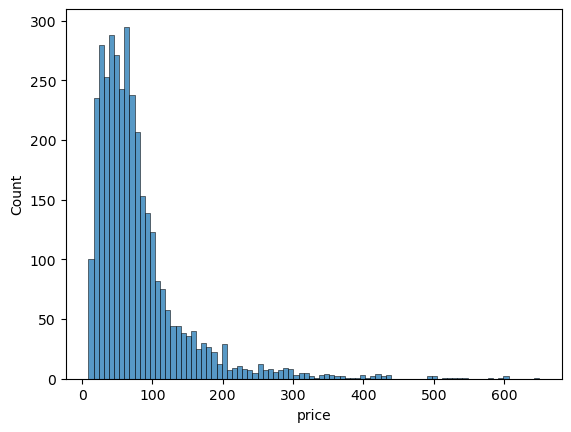

In [312]:
sns.histplot(df[df["host_is_superhost"] == 1]["price"])

In [233]:
df.shape

(18196, 21)

In [234]:
df = df[df["minimum_nights"]<150]

In [235]:
df.shape

(18110, 21)

In [236]:
df = df[df["maximum_nights"]<1500]

In [237]:
df.shape

(18105, 21)

In [238]:
df = df[df["number_of_reviews"]<500]

In [239]:
df.shape

(18082, 21)

In [240]:
df = df[df["amenities"]<1200]

In [241]:
df.shape

(18078, 21)

In [242]:
df = df[df["host_verifications"]<160]

In [243]:
df.shape

(18075, 21)

In [244]:
df = df[df["num_of_baths"] < 7]

In [245]:
df.shape

(18060, 21)

host_is_superhost


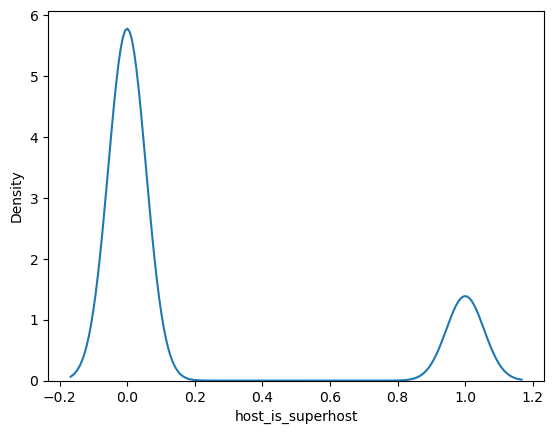

neighbourhood_cleansed


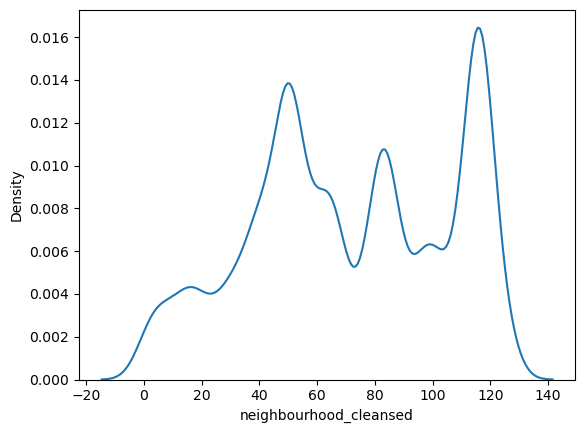

neighbourhood_group_cleansed


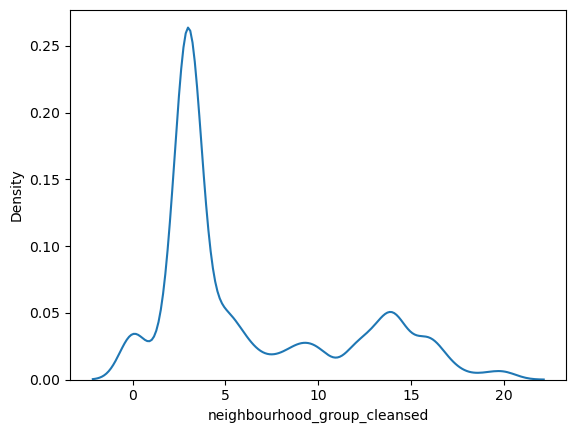

property_type


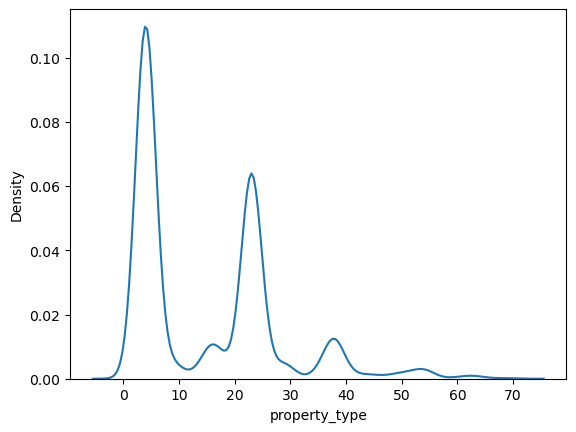

accommodates


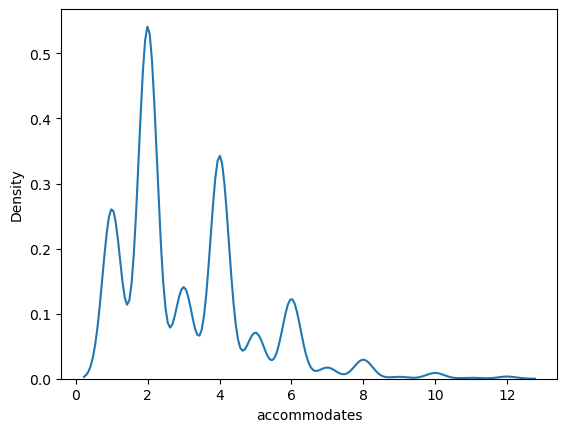

beds


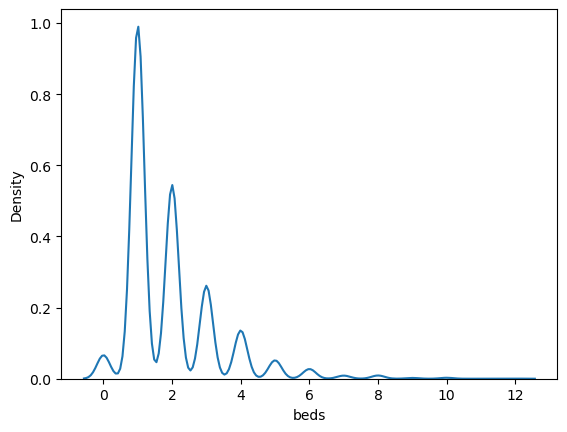

price


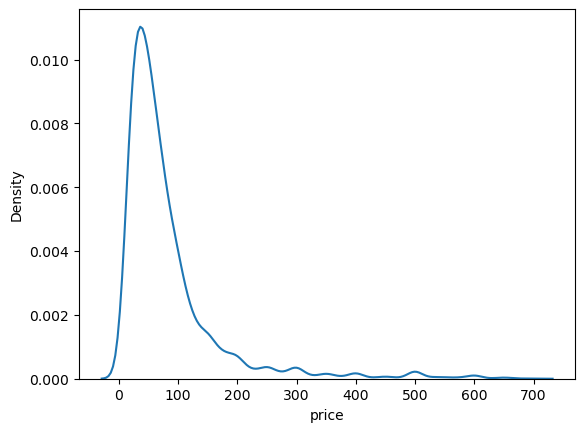

minimum_nights


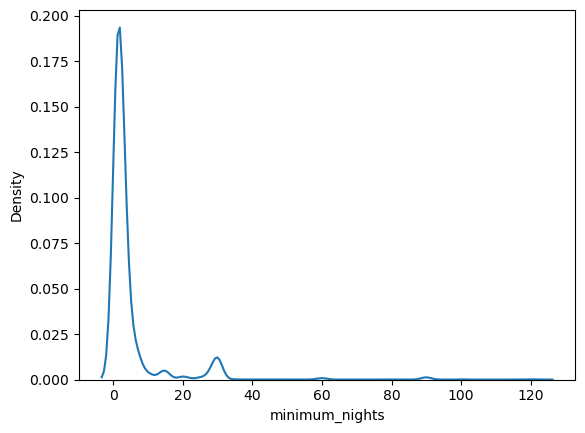

maximum_nights


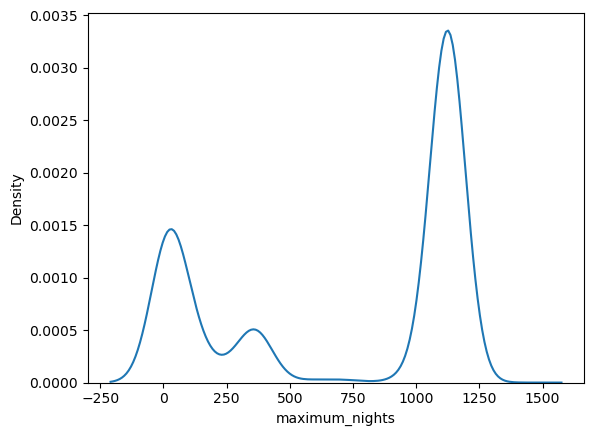

availability_30


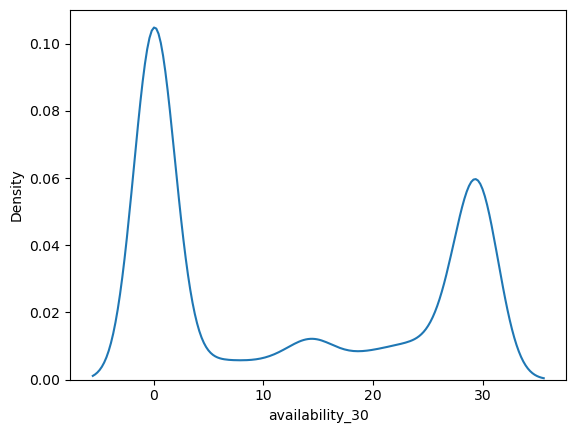

availability_365


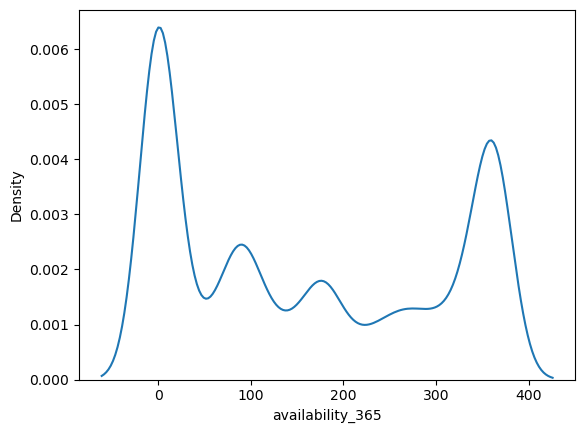

number_of_reviews


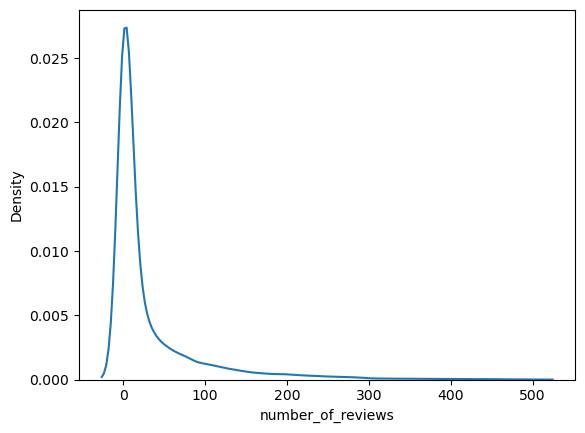

instant_bookable


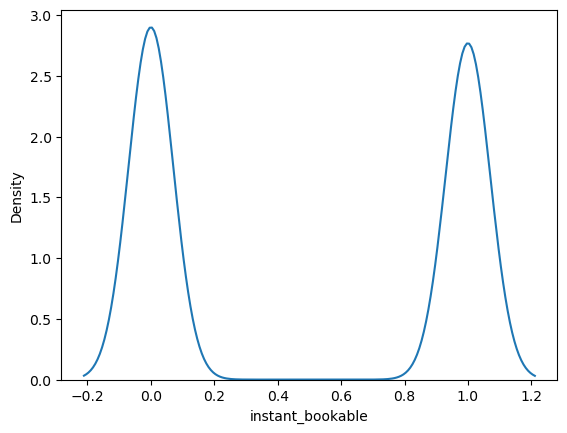

amenities


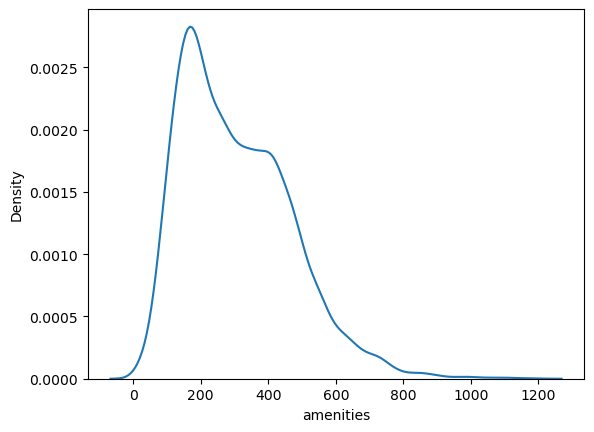

host_verifications


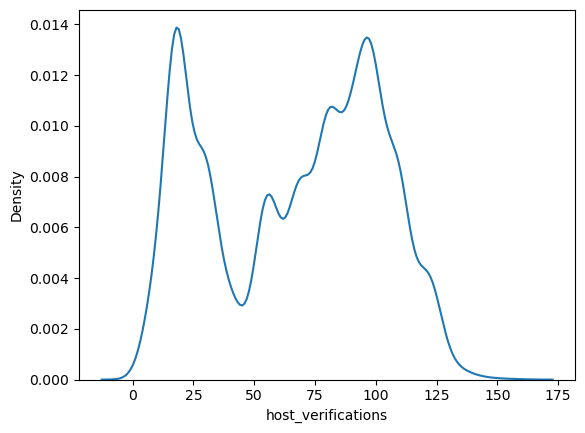

num_of_baths


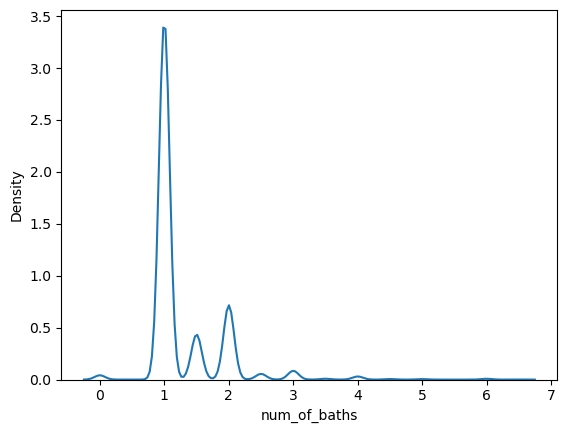

shared_bath


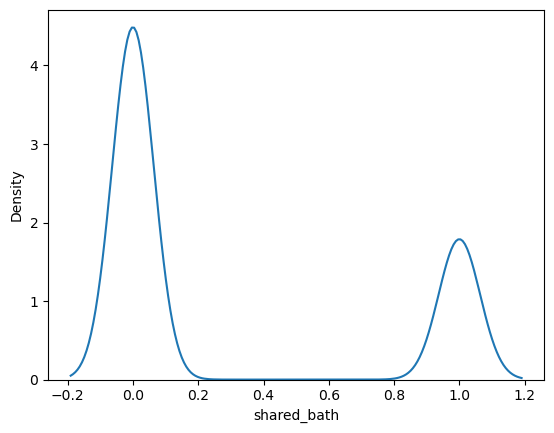

unknoun_bath


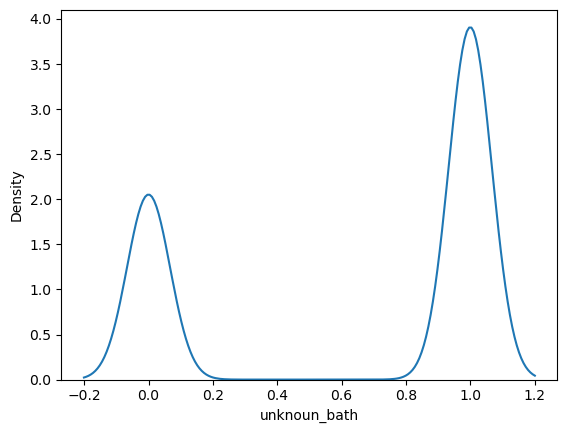

Hotel room


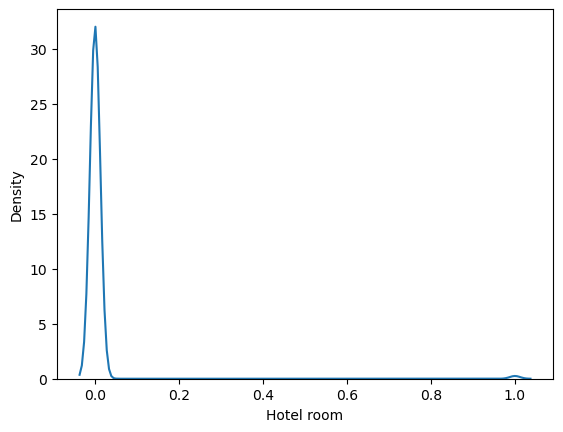

Private room


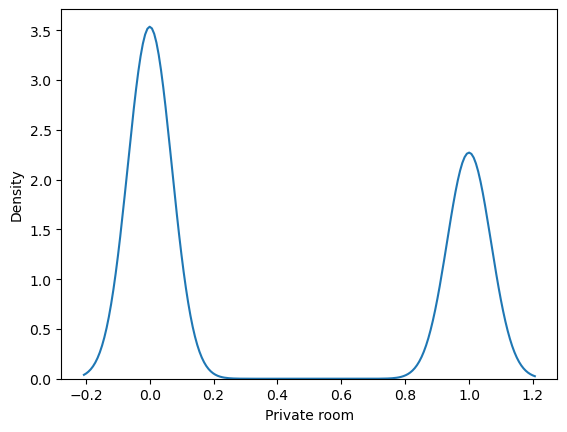

Shared room


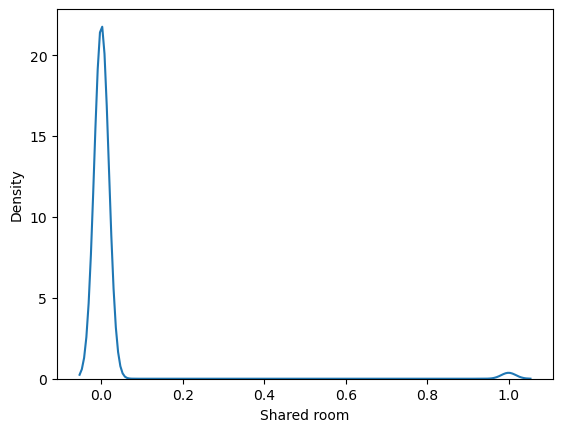

In [246]:
for i in df.columns:
    
    print(i)
    sns.kdeplot(df[i])
    plt.show()

## Dividing x & y

In [298]:
X = df_columns_chosen.drop("price", axis = 1)
y = df_columns_chosen[["price"]]


## Scaling data

In [299]:
from sklearn.preprocessing import MinMaxScaler


scaler_x = MinMaxScaler()
scaler_x.fit(X)
X = scaler_x.transform(X)


scaler_y = MinMaxScaler()
scaler_y.fit(y)
y = scaler_y.transform(y)

# Feature importances

In [300]:
df_class = df_columns_chosen["price"].copy()

In [301]:
df_columns_chosen.drop("price", axis = 1, inplace = True)

C:\Users\ignci\AppData\Local\Temp\ipykernel_8628\1497944178.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_columns_chosen.drop("price", axis = 1, inplace = True)


In [302]:
X = np.asarray(df_columns_chosen)
y = np.asarray(df_class)

In [303]:
X.shape, y.shape

((13981, 7), (13981,))

Feature ranking:
1. feature 1 (0.427530): neighbourhood_group_cleansed
2. feature 6 (0.130615): accommodates
3. feature 5 (0.095485): minimum_nights
4. feature 4 (0.095430): availability_365
5. feature 0 (0.095136): number_of_reviews
6. feature 3 (0.092202): calculated_host_listings_count
7. feature 2 (0.063602): reviews_per_month


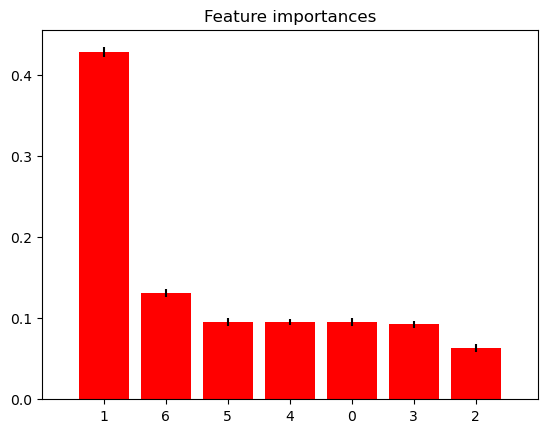

In [304]:
from sklearn.ensemble import ExtraTreesRegressor

# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators = 250,
                              random_state = 0)

forest.fit(X, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f): %s" % (f + 1, indices[f], importances[indices[f]], df_columns_chosen.columns[f]))

# Plot the feature importances of the forest
plt.figure()

plt.title("Feature importances")

plt.bar(range(X.shape[1]), importances[indices], color = "r", yerr = std[indices], align = "center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# 1. LinearRegression

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data: {X_test.shape, y_test.shape}")

Train data: ((11184, 7), (11184,))
Test data: ((2797, 7), (2797,))


In [306]:
# Regresión algorithm

regresion_lineal = LinearRegression()
regresion_lineal.fit(X_train, y_train)

# Finding coef

print ("weights:", regresion_lineal.coef_)
print ("w_0:", regresion_lineal.intercept_)

weights: [-3.87299066e-02  6.68719301e-01 -4.58931449e-04  5.37418247e-02
  8.74845825e-02 -1.06367498e-02 -2.11920756e-01]
w_0: 0.0037176673805094343


## Predicción

In [307]:
yhat = regresion_lineal.predict(X_test)

for i, j in zip(yhat[:5], y_test[:5]):
    print(f"Predicción:{i} \tValor real:{j}")

Predicción:1.0219498911337368 	Valor real:2.3109520213313877
Predicción:-0.36404372440350324 	Valor real:-1.9361292690039211
Predicción:-0.1082777529722592 	Valor real:-0.30234141608561144
Predicción:-1.274160696003128 	Valor real:-1.530230306409548
Predicción:0.5070151191134065 	Valor real:0.3539978899086435


## Metrics

In [308]:
# Sklearn tiene las formulas de algunas métricas en funciones.

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [309]:
# Relative Absolute Error
RAE = np.sum(np.abs(np.subtract(y_test, yhat))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))

# Relative Square Error
RSE = np.sum(np.square(np.subtract(y_test, yhat))) / np.sum(np.square(np.subtract(y_test, np.mean(y_test))))

# Adjusted R**2
r2_ajustada = 1 - (1 - regresion_lineal.score(X_test, y_test))*(len(y_test) - 1)/(len(y_test) - X_test.shape[1] - 1)

In [310]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.5510595439846373
MSE:	 0.5521929648828316
R**2:	 -0.27361684146233656
RAE:	 0.697746312077056
RSE:	 0.5565657880030116
Adjusted R**2:	 0.4420373096965148


In [312]:
# Veamos los valores de yhat, y_test y su diferencia

df_pred = pd.DataFrame()

df_pred["y_test"] = scaler_y.inverse_transform([y_test]).flatten()
df_pred["yhat"] = scaler_y.inverse_transform([yhat]).flatten()

df_pred["diferencia"] = round(abs((df_pred["y_test"] - df_pred["yhat"]) / df_pred["y_test"] * 100), 4)

df_pred = df_pred.sort_values("diferencia")

df_pred.head(20)

,y_test,yhat,diferencia
759,6.196806,6.195661,0.0185
1459,-6.944688,-6.937913,0.0976
1133,-3.947962,-3.943888,0.1032
1162,-11.237779,-11.252924,0.1348
2538,-1.142151,-1.143744,0.1396
1454,4.166448,4.172430,0.1436
636,-3.759681,-3.766081,0.1702
472,-3.051481,-3.043371,0.2658
601,-7.525812,-7.551081,0.3358
1827,-5.417291,-5.398583,0.3453


In [193]:
df_pred.tail(20)

,y_test,yhat,diferencia
2465,0.015917,0.499202,3036.3417
1995,0.015917,0.513598,3126.7875
987,0.015917,0.606108,3708.0013
1892,-0.009428,0.373742,4064.1854
2588,-0.009428,0.386250,4196.8524
1785,0.015917,0.746729,4591.4846
215,-0.009428,0.442198,4790.2809
597,0.015917,-0.772188,4951.4358
269,-0.009428,0.458928,4967.7333
2699,-0.009428,-0.481422,5006.3240


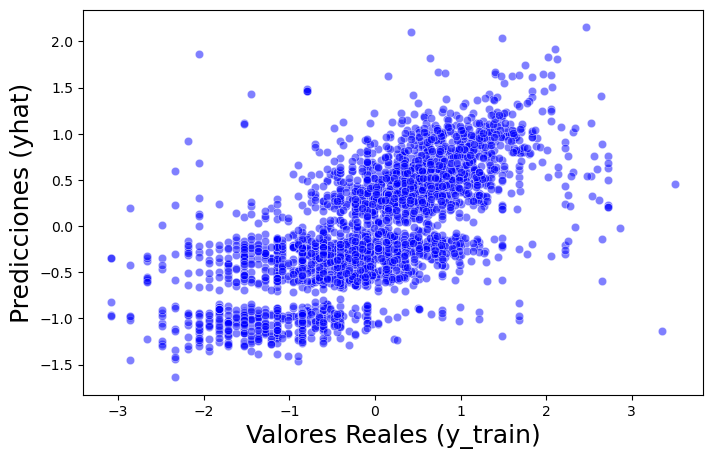

In [313]:
# Distance btw real and predicted values

plt.figure(figsize = (8, 5))

sns.scatterplot(x = y_test.flatten(), y = yhat.flatten(), alpha = 0.5, color = "blue")

plt.xlabel("Valores Reales (y_train)", size = 18)
plt.ylabel("Predicciones (yhat)", size = 18)

plt.show()

# 2. KNeighborsRegressor

In [314]:
from sklearn.neighbors import KNeighborsRegressor

In [315]:
model = KNeighborsRegressor(n_neighbors = 7)

model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [316]:
yhat = model.predict(X_test)

yhat

array([ 0.94324721,  0.2199082 ,  0.0696497 , ..., -0.86405672,
       -0.61620199, -0.20161792])

In [317]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.5353764563552725
MSE:	 0.5209016674078949
R**2:	 0.03553649013181115
RAE:	 0.697746312077056
RSE:	 0.5565657880030116
Adjusted R**2:	 0.4420373096965148


# 3. DecisionTreeRegressor

In [318]:
from sklearn.tree import DecisionTreeRegressor

In [319]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [320]:
yhat = model.predict(X_test)

yhat

array([ 0.51823221, -0.1173205 , -0.30234142, ..., -2.18944414,
        0.01591669, -0.20595769])

In [321]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.6785150298475411
MSE:	 0.907092056172082
R**2:	 0.1290638864725181
RAE:	 0.697746312077056
RSE:	 0.5565657880030116
Adjusted R**2:	 0.4420373096965148


# 4. RandomForestRegressor

In [322]:
from sklearn.ensemble import RandomForestRegressor

In [323]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [324]:
yhat = model.predict(X_test)

yhat

array([ 1.15914226, -0.02051351, -0.17642213, ..., -1.34293821,
       -1.00765603, -0.16780444])

In [325]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.47747897945208173
MSE:	 0.43514935633988355
R**2:	 0.2547671005889459
RAE:	 0.697746312077056
RSE:	 0.5565657880030116
Adjusted R**2:	 0.4420373096965148


# 4. AdaBoostRegressor

In [326]:
from sklearn.ensemble import AdaBoostRegressor

In [327]:
model = AdaBoostRegressor(n_estimators = 50)
model.fit(X_train, y_train)


AdaBoostRegressor()

In [328]:
yhat = model.predict(X_test)

yhat

array([ 0.65690081, -0.24724128,  0.82761652, ..., -0.6682791 ,
       -0.50453605,  0.48152734])

In [329]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.5943876393316763
MSE:	 0.614496742917528
R**2:	 -1.1747205341552092
RAE:	 0.697746312077056
RSE:	 0.5565657880030116
Adjusted R**2:	 0.4420373096965148


In [211]:
model.base_estimator_

DecisionTreeRegressor(max_depth=3)

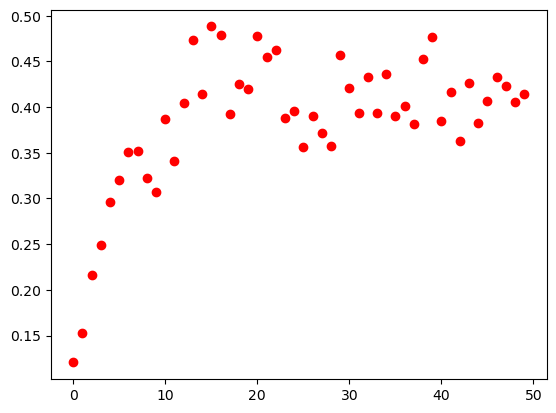

In [212]:
plt.plot(model.estimator_errors_, marker = "o", color = "red", linestyle = "")
plt.show()

In [213]:
model.feature_importances_

array([0.0766491 , 0.00851374, 0.11080968, 0.09338781, 0.16946633,
       0.01081481, 0.07765391, 0.07444356, 0.01181598, 0.05223956,
       0.01471137, 0.22439699, 0.07509717])

In [214]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [ ]:
import pickle
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

# Exportar modelos usando pickle con extensión ".sav"
with open("random_forest_clf.sav", "wb") as file:
    pickle.dump(model, file)
    
# Importar modelos usando pickle con extensión ".sav"
with open("random_forest_clf.sav", "rb") as file:
    model = pickle.load(file)
    
# También se puede usar extensión ".pkl"

# Mapa

In [44]:
# df.columns

In [45]:
# df['neighbourhood_group_cleansed'].unique()

In [46]:
# with open("neighbourhoods.geojson", "r") as file:
    
#     geojson = file.read()
    
# pprint(geojson)

In [47]:
# df_map = df.groupby('neighbourhood_group_cleansed', as_index=False).mean()
# df_map

In [48]:
# df_map = df_map[df_map["price"]<200]

In [49]:
# df_map

In [50]:
# sns.histplot(df_map["price"])

In [51]:
# world_map = folium.Map(location = [40.18893909782826, -3.938873736090105], zoom_start =12)

# folium.Choropleth(geo_data     = geojson,
#                   data         = df_map,
#                   columns      = ["neighbourhood_group_cleansed", "price"],
#                   key_on       = "feature.properties.neighbourhood_group",
#                   fill_color   = "Blues_r", 
#                   fill_opacity = 0.7, 
#                   line_opacity = 0.2,
#                   legend_name  = "Precio airbnb",
#                   bins         = 253,
#                   highlight    = True).add_to(world_map)

# world_map